In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
import rasterio
from rasterio.plot import show
import contextily
url = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}'

In [3]:
import core

## Download staged test data
- DEMs over Deming and Easton glaciers at Mt Baker
- Points along a random transect over variable terrain

In [4]:
import driveanon

In [5]:
# %%capture
# driveanon.save('1VyUqu2519Hn9G4wlavXKGBpJQ5gXyZIR', filename='easton_data.tar.gz')
# ! tar -xzvf easton_data.tar.gz
# ! rm easton_data.tar.gz

In [6]:
dem_file_list = sorted(glob.glob('easton_data/*.tif'))

In [7]:
dem_file_list

['easton_data/1970-09-29_01m.tif',
 'easton_data/1970-09-29_10m.tif',
 'easton_data/1970-09-29_20m.tif',
 'easton_data/1970-09-29_30m.tif',
 'easton_data/1970-09-29_60m.tif',
 'easton_data/1970-09-29_90m.tif']

In [8]:
positions  = np.load('easton_data/easton.npy')
len(positions)

1400

## Read in first highest resolution DEM
- sample at points using cubic interpolation

In [9]:
raster_file_name = dem_file_list[0]
source = rasterio.open(raster_file_name)

In [10]:
validation_data = core.interpolate(raster_file_name, positions, offset=3, kind='cubic')

<AxesSubplot:>

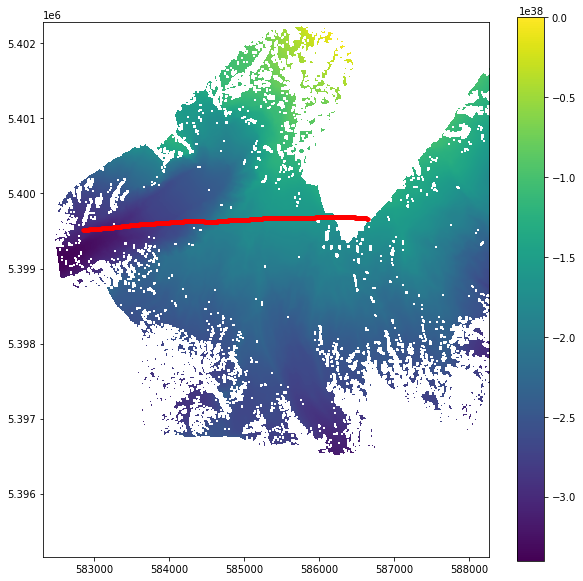

In [11]:
fig,ax = plt.subplots(figsize=(10,10))
ax.scatter(*zip(*positions), c='r',marker='.')
fig.colorbar(ax.imshow(source.read(1)),ax=ax)
show(source,ax=ax)

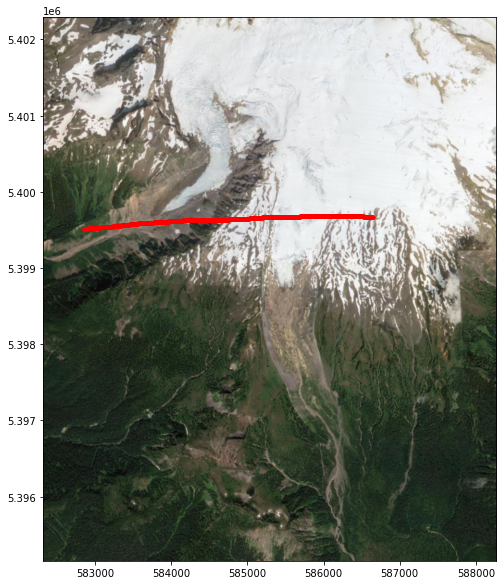

In [12]:
fig,ax = plt.subplots(figsize=(10,10))
ax.scatter(*zip(*positions), c='r',marker='.')
show(source,ax=ax,alpha=0)
contextily.add_basemap(ax, 
                       source = url,
                       crs='EPSG:'+str(source.crs.to_epsg()))

In [13]:
distances = core.distance_along_transect(positions)

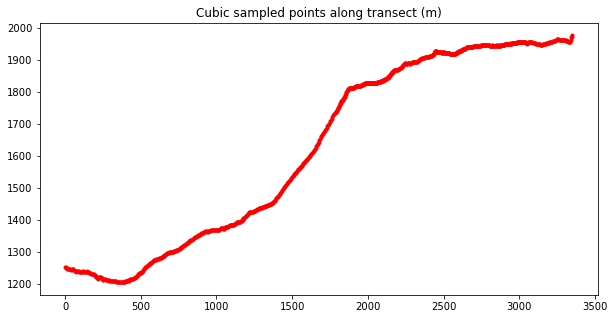

In [14]:
fig,ax = plt.subplots(figsize=(10,5))
ax.scatter(distances, validation_data, c='r',marker='.')
ax.set_title('Cubic sampled points along transect (m)');

## Test interpolation methods
- see core.py and synthetic_data_example.ipynb for further details

In [15]:
columns = []
for raster_file_name in dem_file_list[:]:
    col = os.path.split(raster_file_name)[-1].split('.')[0][-3:].lstrip('0')
    columns.append(col)

In [16]:
rmse_df = pd.DataFrame(columns = columns,  
                        index = ['window_mean', 'window_IDW', 'window_rio_nn', 'window_nn',
                                 'scipy_linear', 'scipy_cubic', 'scipy_quintic']) 

abs_diff_df = rmse_df.copy()
diff_df = rmse_df.copy()

In [17]:
dfs = []
for raster_file_name in dem_file_list[:]:
    col = os.path.split(raster_file_name)[-1].split('.')[0][-3:].lstrip('0')
    window_mean   = core.interpolate(raster_file_name, positions, offset=3, kind='mean')
    window_IDW    = core.interpolate(raster_file_name, positions, offset=3, kind='IDW')
    window_rio_nn = core.interpolate(raster_file_name, positions, offset=3, kind='rio_NN')
    window_nn     = core.interpolate(raster_file_name, positions, offset=3, kind='NN')
    scipy_linear  = core.interpolate(raster_file_name, positions, offset=3, kind='linear')
    scipy_cubic   = core.interpolate(raster_file_name, positions, offset=3, kind='cubic')
    scipy_quintic = core.interpolate(raster_file_name, positions, offset=3, kind='quintic')
    
    df = pd.DataFrame.from_dict(
        {
            "validation": validation_data,
            "window_mean": window_mean,
            "window_IDW": window_IDW,
            "window_rio_nn": window_rio_nn,
            "window_nn": window_nn,
            "scipy_linear": scipy_linear,
            "scipy_cubic": scipy_cubic,
            "scipy_quintic": scipy_quintic,
        }
    )
    
    rmse_df[col] = (df.sub(df['validation'],axis=0)**2).mean() **.5
    abs_diff_df[col] = df.sub(df['validation'],axis=0).abs().mean()
    
    dfs.append(df)


Optimal IDW power: 2.8000000000000003
Optimal IDW power: 1.8
Optimal IDW power: 2.6
Optimal IDW power: 2.4000000000000004
Optimal IDW power: 2.5
Optimal IDW power: 3.1


## Compare RMSE against validation data
- using final lowest resolution DEM in loop

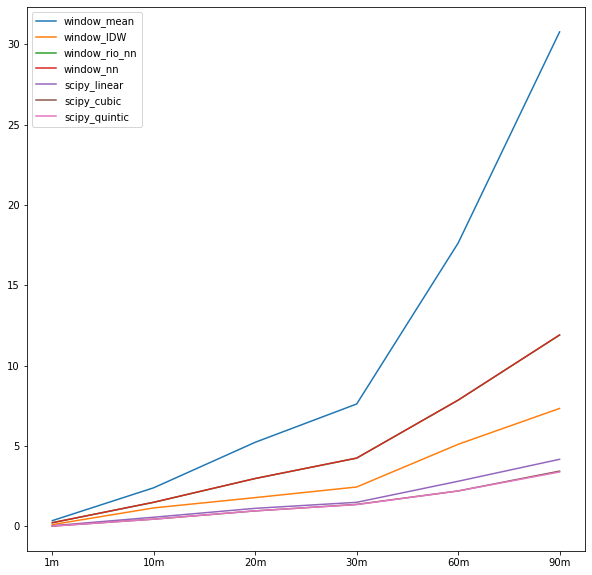

In [18]:
rmse_df.transpose().plot(figsize=(10,10));

## Compare all errors to cubic interpolated result
- RMSE of RMSEs at all resolutions
- Assuming cubic interpolation performed the best

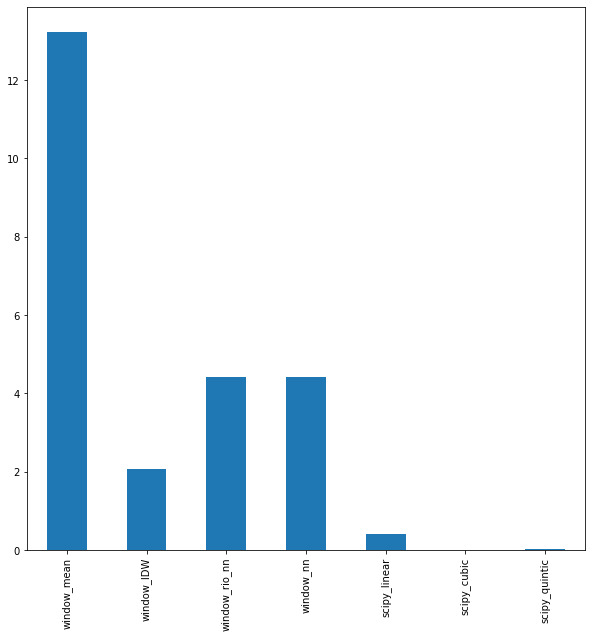

In [19]:
((rmse_df.transpose().sub(rmse_df.transpose()['scipy_cubic'],axis=0)**2).mean() **.5).plot.bar(figsize=(10,10));

## Examine 30 m interpolated results

In [20]:
dem_file_list

['easton_data/1970-09-29_01m.tif',
 'easton_data/1970-09-29_10m.tif',
 'easton_data/1970-09-29_20m.tif',
 'easton_data/1970-09-29_30m.tif',
 'easton_data/1970-09-29_60m.tif',
 'easton_data/1970-09-29_90m.tif']

In [21]:
df = dfs[3]
df['distances'] = distances
df = df.set_index('distances')

<AxesSubplot:>

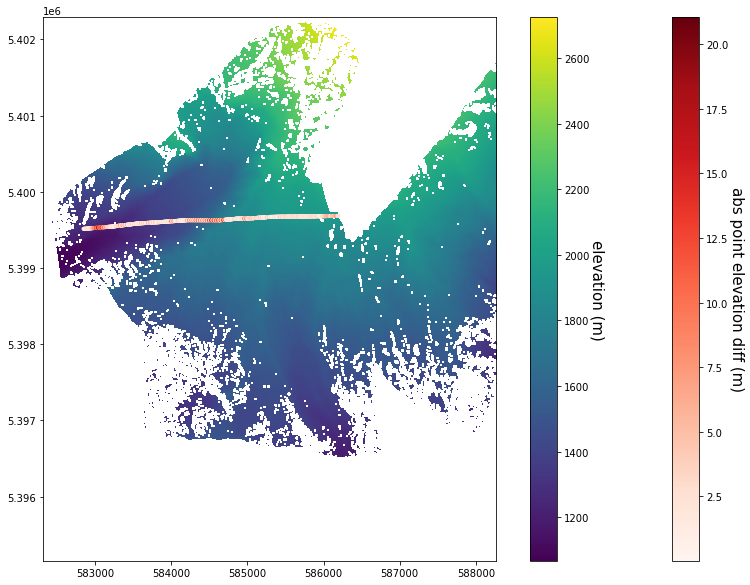

In [22]:
z = df.sub(df['validation'],axis=0).abs()['window_rio_nn']

fig,ax = plt.subplots(figsize=(15,10))
fig.colorbar(ax.scatter(*zip(*positions), 
                        c=z, 
                        cmap='Reds',
                        marker='.')).set_label('abs point elevation diff (m)',
                                               rotation=270,
                                               labelpad=15,
                                               size=15)

fig.colorbar(ax.imshow(source.read(1,masked=True)),ax=ax).set_label('elevation (m)', 
                                                                    rotation=270, 
                                                                    labelpad=15,
                                                                    size=15)
show(source,ax=ax)


(0.0, 3804.1068662860653)

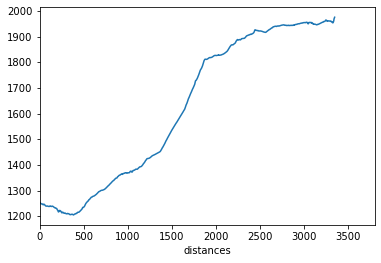

In [23]:
df['validation'].plot().set_xlim(0,max(distances))

(0.0, 3804.1068662860653)

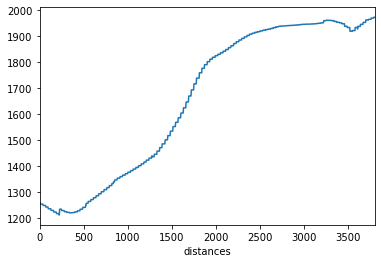

In [24]:
df['window_mean'].plot().set_xlim(0,max(distances))

(0.0, 3804.1068662860653)

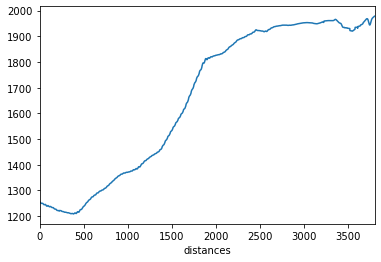

In [25]:
df['window_IDW'].plot().set_xlim(0,max(distances))

(0.0, 3804.1068662860653)

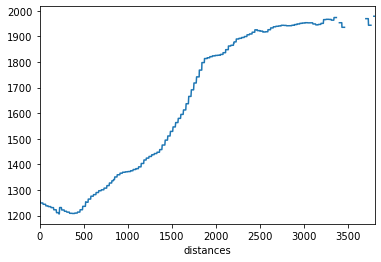

In [26]:
df['window_rio_nn'].plot().set_xlim(0,max(distances))

(0.0, 3804.1068662860653)

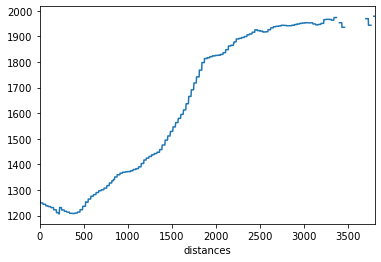

In [27]:
df['window_nn'].plot().set_xlim(0,max(distances))

(0.0, 3804.1068662860653)

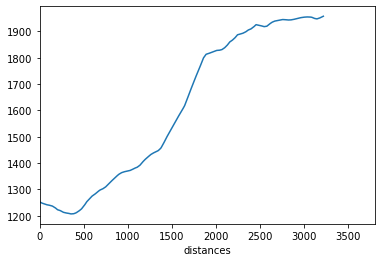

In [28]:
df['scipy_linear'].plot().set_xlim(0,max(distances))

(0.0, 3804.1068662860653)

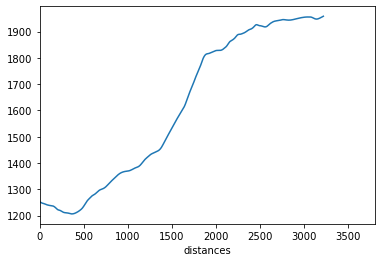

In [29]:
df['scipy_cubic'].plot().set_xlim(0,max(distances))

(0.0, 3804.1068662860653)

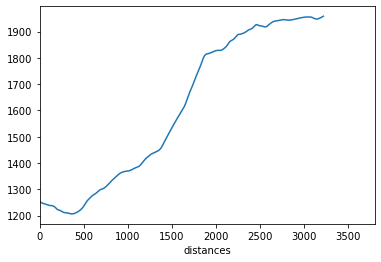

In [30]:
df['scipy_quintic'].plot().set_xlim(0,max(distances))

## Preliminary takeaways

Nearest neighbor can be off by roughly 20 cm - 8 m on average, depending on the resolution of the DEM being sampled, compared to cubic interpolated results.

- mean is the worst
- IDW is better than nearest neighbor
- linear is better than IDW
- cubic and quintic give the best results and are nearly the same
- mean, nearest neighber, and IDW are robust to nan values within sampling window

### How bad is nearest neighbor compared to cubic interpolation?

<AxesSubplot:>

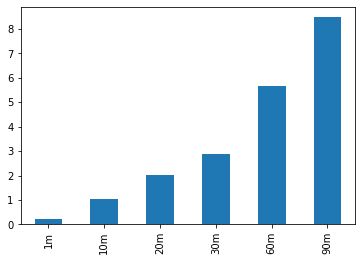

In [31]:
(rmse_df.transpose()['window_rio_nn'] - rmse_df.transpose()['scipy_cubic']).plot.bar()

## Compare to rasterstats

In [106]:
from rasterstats import point_query

In [107]:
columns = []
for raster_file_name in dem_file_list[:]:
    col = os.path.split(raster_file_name)[-1].split('.')[0][-3:].lstrip('0')
    columns.append(col)
    
rmse_df = pd.DataFrame(columns = columns,  
                        index = ['rasterstats_bilinear', 'rasterstats_nearest', 'scipy_linear', 'scipy_cubic',
                                'window_IDW']) 

In [109]:
rasterstats_dfs = []

for raster_file_name in dem_file_list[:]:
    rasterstats_bilinear = []
    rasterstats_nearest = []
    
    col = os.path.split(raster_file_name)[-1].split('.')[0][-3:].lstrip('0')
    
    for p in positions:
        p = {'type': 'Point', 'coordinates': p}
        rasterstats_bilinear.extend(point_query(p, raster_file_name,interpolate='bilinear'))
        rasterstats_nearest.extend(point_query(p, raster_file_name,interpolate='nearest'))
        
    scipy_linear  = core.interpolate(raster_file_name, positions, offset=3, kind='linear')
    scipy_cubic   = core.interpolate(raster_file_name, positions, offset=3, kind='cubic')
    window_IDW    = core.interpolate(raster_file_name, positions, offset=3, kind='IDW')
    
    df = pd.DataFrame.from_dict(
        {
            "validation": validation_data,
            "rasterstats_bilinear":rasterstats_bilinear,
            "rasterstats_nearest":rasterstats_nearest,
            "scipy_linear":scipy_linear,
            "scipy_cubic": scipy_cubic,
            "window_IDW": window_IDW
            
        }
    )
    
    
    rmse_df[col] = (df.sub(df['validation'],axis=0)**2).mean() **.5
    
    rasterstats_dfs.append(df)

Optimal IDW power: 2.8000000000000003
Optimal IDW power: 1.8
Optimal IDW power: 2.6
Optimal IDW power: 2.4000000000000004
Optimal IDW power: 2.5
Optimal IDW power: 3.1


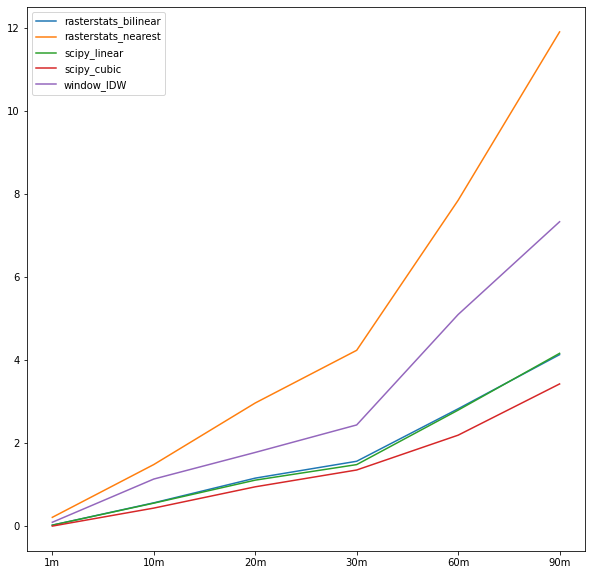

In [110]:
rmse_df.transpose().plot(figsize=(10,10));

In [111]:
df = rasterstats_dfs[3]
df['distances'] = distances
df = df.set_index('distances')

(0.0, 3804.1068662860653)

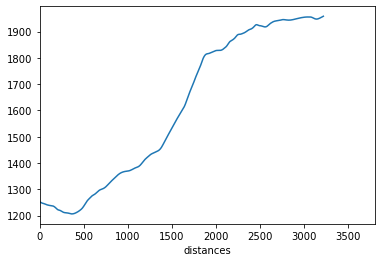

In [112]:
df['scipy_cubic'].plot().set_xlim(0,max(distances))

(0.0, 3804.1068662860653)

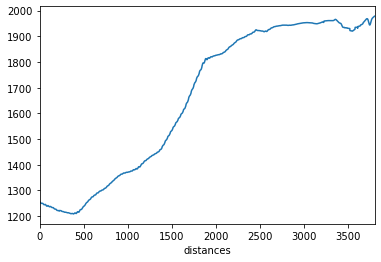

In [113]:
df['window_IDW'].plot().set_xlim(0,max(distances))

(0.0, 3804.1068662860653)

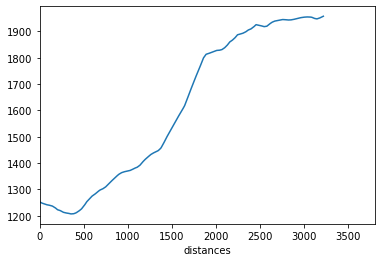

In [114]:
df['scipy_linear'].plot().set_xlim(0,max(distances))

(0.0, 3804.1068662860653)

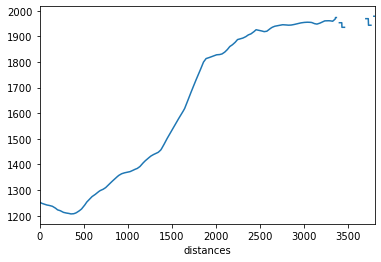

In [115]:
df['rasterstats_bilinear'].plot().set_xlim(0,max(distances))

<AxesSubplot:>

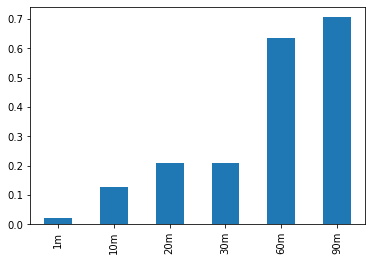

In [116]:
(rmse_df.transpose()['rasterstats_bilinear'] - rmse_df.transpose()['scipy_cubic']).plot.bar()

### Takeaway
- Results very similar to custom `scipy_linear` result
- Nice that it defaults to nearest neighbor if nans in window. This produces a more complete set of points. Could probably implement something similar of just use this rasterstats package.
- Cubic interpolation appears to have a slightly lower RMSE than the bi-linear rasterstats approach.


## Compare to demquery
- Can't handle nans in default window sizes. All methods fail. 
- Window sizes can't be modified on input and are too large by default. 

In [33]:
from demquery import Query

In [98]:
query = Query(dem_file_list)

In [105]:
# elevations = query.query_points(positions, interp_kind='linear')
# elevations = query.query_points(positions, interp_kind='cubic')
# elevations = query.query_points(positions, interp_kind='quintic')